In [1]:
import MDAnalysis as mda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from MDAnalysis.lib.distances import distance_array
from MDAnalysis import units
from MDAnalysis.analysis import rdf
from openmm.unit import AVOGADRO_CONSTANT_NA, BOLTZMANN_CONSTANT_kB
from openmm.unit import kelvin, bar, litre, kilojoule_per_mole, mole, nanometer, angstrom, kilocalorie_per_mole
from openmm.unit import Quantity, Unit


/tmp/ipykernel_3285946/1846008544.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Loading data and creating atom group of ions

In [2]:
u = mda.Universe('md.gro', 'md.xtc')
print(u, '\n', u.atoms, '\n', u.trajectory)

ions= u.select_atoms('resname NA CL')
print(len(u.trajectory))

waters=u.select_atoms('resname SOL')
nas=u.select_atoms('resname NA')
cls=u.select_atoms('resname CL')

box_size = u.dimensions[:3] * angstrom
print(box_size)

<Universe with 8159 atoms> 
 <AtomGroup [<Atom 1: OW of type O of resname SOL, resid 17 and segid SYSTEM>, <Atom 2: HW1 of type H of resname SOL, resid 17 and segid SYSTEM>, <Atom 3: HW2 of type H of resname SOL, resid 17 and segid SYSTEM>, ..., <Atom 8157: OW of type O of resname SOL, resid 2725 and segid SYSTEM>, <Atom 8158: HW1 of type H of resname SOL, resid 2725 and segid SYSTEM>, <Atom 8159: HW2 of type H of resname SOL, resid 2725 and segid SYSTEM>]> 
 <XTCReader md.xtc with 251 frames of 8159 atoms>
251
[30.211418 30.211418 90.63425 ] A


## Function for calculating osmotic values:

In [3]:

R = BOLTZMANN_CONSTANT_kB * AVOGADRO_CONSTANT_NA # gas constant

def osmotic_values(mean_force_wall, molarity :Quantity, vant_hoff : int=2, T=300*kelvin, cross_sectional_area : Quantity=30*30 * angstrom**2 ):
    osm_press=mean_force_wall/cross_sectional_area
    osm_bar = osm_press.in_units_of(bar / mole)
    osm_bar = osm_bar/AVOGADRO_CONSTANT_NA
    print(f"Osmotic Pressure Observed:", osm_bar)
    osm_press_ideal=vant_hoff*molarity*R*T
    osm_press_ideal=osm_press_ideal.in_units_of(bar)
    print(f"Osmotic Pressure Ideal:", osm_press_ideal)
    osm_coeff=osm_bar/osm_press_ideal
    #osm_coeff=(osm_bar/(vant_hoff* molarity * R * T))*101.32 #Osmotic pressure to osmotic coefficient
    print(f"Osmotic Coefficient:", osm_coeff)

    return osm_coeff

def calculate_net_force(z_values : np.ndarray[float], zwall : float, k : float) -> float:
    return k * abs(z_values - zwall).sum()

In [4]:
k_nm = 4184 * kilojoule_per_mole / nanometer**2
k = k_nm.in_units_of(kilojoule_per_mole / angstrom**2)

walls_z_pos = np.array([30, 60]) * angstrom
forces_at_ts = {
    30 : [],
    60 : []
}
for _ in u.trajectory:
    ions_z = ions.positions[:,2]*angstrom
    force_30 = calculate_net_force(
        z_values=ions_z[ions_z < 30*angstrom],
        zwall=30*angstrom,
        k=k
    )
    forces_at_ts[30].append(force_30)

    force_60 = calculate_net_force(
        z_values=ions_z[ions_z > 60*angstrom],
        zwall=60*angstrom,
        k=k
    )
    forces_at_ts[60].append(force_60)

mean_forces = {
    abs_wall_z : sum(force_list, start=0*(kilojoule_per_mole / angstrom)) / len(u.trajectory)
        for abs_wall_z, force_list in forces_at_ts.items()
}
mean_forces

{30: Quantity(value=0.17835820475422529, unit=kilojoule/(angstrom*mole)),
 60: Quantity(value=5.067512510991189, unit=kilojoule/(angstrom*mole))}

In [5]:
box_x = box_size[0]
box_y = box_size[1]
A_box = box_x * box_y

dim_mem = walls_z_pos.ptp() * walls_z_pos.unit
V_mem = A_box * dim_mem

n_part = 16
M = n_part / (V_mem * AVOGADRO_CONSTANT_NA)
M = M.in_units_of(mole / litre)
print(M)

for wall_z_val, mF in mean_forces.items():
    print(wall_z_val)
    o = osmotic_values(mF, molarity=M, cross_sectional_area=A_box)

0.9702990286768957 mol/L
30
Osmotic Pressure Observed: 3.244889865554619 bar
Osmotic Pressure Ideal: 48.40509001418668 bar
Osmotic Coefficient: 0.06703612914682316
60
Osmotic Pressure Observed: 92.1937962604269 bar
Osmotic Pressure Ideal: 48.40509001418668 bar
Osmotic Coefficient: 1.904630199704339


In [6]:
av_mF=(mean_forces[30]+mean_forces[60])/2
o = osmotic_values(av_mF, molarity=M, cross_sectional_area=A_box)

Osmotic Pressure Observed: 47.71934306299075 bar
Osmotic Pressure Ideal: 48.40509001418668 bar
Osmotic Coefficient: 0.9858331644255811


## Na-Oxygen Distances (RDF)

Text(0.5, 1.0, 'Na-Oxygen Distances')

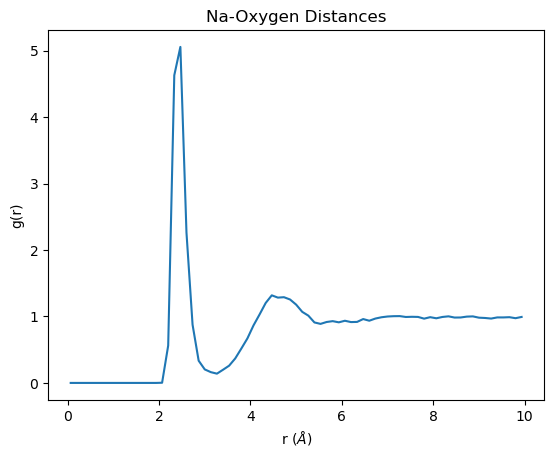

In [9]:
from MDAnalysis.analysis.rdf import InterRDF
ows=u.select_atoms('name OW')
irdf = InterRDF(ows, nas, nbins=75, range=(0,10))
irdf.run(start=-200)


plt.plot(irdf.results.bins, irdf.results.rdf)
plt.xlabel('r ($\AA$)')
plt.ylabel('g(r)')
plt.title('Na-Oxygen Distances')

## Cl-Oxygen Distances (RDF)

Text(0.5, 1.0, 'Cl-Oxygen Distances')

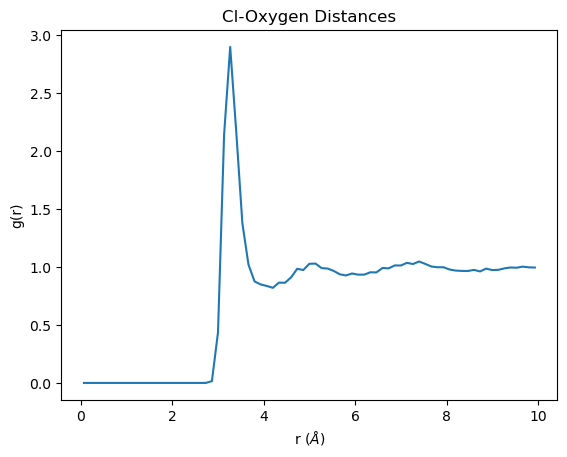

In [10]:
irdf = InterRDF(ows, cls, nbins=75, range=(0,10))
irdf.run(start=-200)


plt.plot(irdf.results.bins, irdf.results.rdf)
plt.xlabel('r ($\AA$)')
plt.ylabel('g(r)')
plt.title('Cl-Oxygen Distances')